# Optical Character Recognition

In [56]:
import torch
import numpy as np
import pandas as pd
import random
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader, TensorDataset
from PIL import Image, ImageDraw, ImageFont
import nltk
from nltk.corpus import words
import os
import sys
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '../..')))
import torch.nn.functional as F
import matplotlib.pyplot as plt
import string

In [64]:
def render_word_image(word, img_size=(256, 64), font_path="arial.ttf", font_size=32, save = False):
    img = Image.new('L', img_size, color='white') 
    draw = ImageDraw.Draw(img)


    font = ImageFont.truetype(font_path, font_size)

    bbox = draw.textbbox((0, 0), word, font=font)
    text_width, text_height = bbox[2] - bbox[0], bbox[3] - bbox[1]
    position = ((img_size[0] - text_width) // 2, (img_size[1] - text_height) // 2)

    draw.text(position, word, fill='black', font=font)
    
    if save:
        return img
    
    return np.array(img),word

In [61]:
def create_words_dataset(save = False):
    nltk.download('words')
    word_list = words.words()

    filtered_words = [word for word in word_list if word.isascii() and len(word) <= 20]
    word_list = random.sample(filtered_words, min(100000, len(filtered_words)))

    if save:
        output_dir = "../../data/external/word_images"
        os.makedirs(output_dir, exist_ok=True)

        for idx, word in enumerate(word_list):
            img = render_word_image(word)
            img.save(os.path.join(output_dir, f"{word}_{idx}.png"))

        print("Dataset created.")

    return word_list

    

In [62]:
word_list = create_words_dataset()

[nltk_data] Downloading package words to /home/samkit/nltk_data...
[nltk_data]   Package words is already up-to-date!


In [65]:
dataset = [render_word_image(word) for word in word_list]


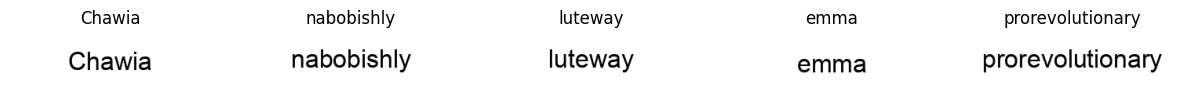

In [66]:
selected_images = random.sample(dataset, 5)

# Plot the selected images
fig, axes = plt.subplots(1, 5, figsize=(15, 5))  # Create a subplot with 5 images

for i, (img_array, label) in enumerate(selected_images):
    axes[i].imshow(img_array, cmap='gray')  
    axes[i].axis('off')  # Hide the axes
    axes[i].set_title(label)  # Set the title as the label (word)

plt.show()

In [67]:
train_len = int(len(dataset)*0.8)
test_len = int(len(dataset)*0.1)
val_len = len(dataset) - train_len - test_len
train_set = dataset[:train_len]
test_set = dataset[train_len:train_len + test_len]
val_set = dataset[train_len + test_len:]

In [68]:
images = np.array([img_array for img_array, _ in dataset])  # Stack all images into a numpy array
labels = np.array([word for _, word in dataset])

In [69]:
char_set = string.ascii_lowercase + string.ascii_uppercase
char_to_idx = {char: idx + 1 for idx, char in enumerate(char_set)} 

def encode_word(word, max_length):
    encoded = [char_to_idx.get(char, 0) for char in word[:max_length]]  
    encoded += [0] * (max_length - len(encoded))  
    return encoded

In [70]:
def create_loaders(dataset, max_length):

    images = np.array([img_array for img_array, _ in dataset], dtype=np.float32) / 255.0
    labels = [encode_word(word, max_length) for _, word in dataset]

    images = torch.tensor(images, dtype=torch.float32).unsqueeze(1)  # (N, C, H, W)
    labels = torch.tensor(labels, dtype=torch.float32)

    train_len = int(len(dataset) * 0.8)
    test_len = int(len(dataset) * 0.1)
    val_len = len(dataset) - train_len - test_len
    train_images, train_labels = images[:train_len], labels[:train_len]
    val_images, val_labels = images[train_len:train_len + val_len], labels[train_len:train_len + val_len]
    test_images, test_labels = images[train_len + val_len:], labels[train_len + val_len:]

    train_loader = DataLoader(TensorDataset(train_images, train_labels), batch_size=32, shuffle=True)
    val_loader = DataLoader(TensorDataset(val_images, val_labels), batch_size=32, shuffle=False)
    test_loader = DataLoader(TensorDataset(test_images, test_labels), batch_size=32, shuffle=True)

    return train_loader, val_loader, test_loader

In [71]:
train_loader, val_loader, test_loader = create_loaders(dataset, 20)

In [80]:
class CRNN(nn.Module):
    def __init__(self, kernels, cnn_out, encoder_out, rnn_hidden_size, num_layers = 2, num_classes = 53, dropout=0.2, normalize=True):

        super(CRNN, self).__init__()

        self.normalize = normalize

        self.cnn = nn.ModuleList()
        for i in range(1, len(kernels)):
            self.cnn.append(nn.Conv2d(in_channels=kernels[i - 1][0], out_channels=kernels[i][0], kernel_size=kernels[i][1], stride=kernels[i][2], padding=1))
            if self.normalize:
                self.cnn.append(nn.BatchNorm2d(kernels[i][0]))
            self.cnn.append(nn.ReLU())
            self.cnn.append(nn.MaxPool2d(2, 2))

        self.num_layers = num_layers
        self.cnn = nn.Sequential(*self.cnn)

        self.fc = nn.Linear(encoder_out, cnn_out)

        self.dropout = dropout

        self.rnn = nn.RNN(
            input_size=cnn_out,
            hidden_size=rnn_hidden_size,
            num_layers=self.num_layers,
            batch_first=True,
            nonlinearity='relu',
            dropout=self.dropout
        )

        if self.normalize:
            self.batch_norm = nn.BatchNorm1d(rnn_hidden_size)

        self.fc_out = nn.Linear(rnn_hidden_size, num_classes)

    def forward(self, x):

        batch_size = x.size(0)
        x = self.cnn(x)
        x = x.view(batch_size, -1)
        x = self.fc(x)
        x = x.unsqueeze(1).repeat(1, 20, 1)
        x, _ = self.rnn(x)
        output = self.fc_out(x)
        return output

    def train_model(self, train_loader, val_loader, epochs, device, lr=0.001):
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(self.parameters(), lr=lr)
        self.to(device)
        train_losses, val_losses = [], []


        for epoch in range(epochs):
            self.train()
            running_loss = 0.0

            for _, (images, labels) in enumerate(train_loader):
                images, labels = images.to(device), labels.to(device)
                outputs = self(images)
                labels = labels.view(-1).long()
                outputs = outputs.view(-1, outputs.size(2))
                loss = criterion(outputs, labels)
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                running_loss += loss.item()

            running_loss /= len(train_loader)
            val_loss = self.evaluate_model(val_loader, device)
            val_losses.append(val_loss)
            train_losses.append(running_loss)
            print(f"Epoch {epoch + 1}/{epochs}: Train Loss: {running_loss:.4f}, Validate Loss: {val_loss:.4f}")

        return train_losses, val_losses

    def evaluate_model(self, val_loader, device, padding_idx=0):

        criterion = nn.CrossEntropyLoss()

        idx_to_char = {0: '<PAD>'}

        for i, char in enumerate("abcdefghijklmnopqrstuvwxyz", start=1):
            idx_to_char[i] = char

        for i, char in enumerate("ABCDEFGHIJKLMNOPQRSTUVWXYZ", start=len(idx_to_char)):
            idx_to_char[i] = char

        self.to(device)
        self.eval()
        val_loss = 0.0
        correct_chars = 0
        total_chars = 0
        random_correct_chars = 0
        with torch.no_grad():
            for i, (images, labels) in enumerate(val_loader):
                images, labels = images.to(device), labels.to(device)
                outputs = self(images)
                labels = labels.view(-1).long()
                outputs = outputs.view(-1, outputs.size(2))
                loss = criterion(outputs, labels)
                val_loss += loss.item()
    
                _, predicted = torch.max(outputs, 1)

                predicted = predicted.view(-1)
                true_labels = labels.view(-1)

                non_padding_mask = true_labels != padding_idx
    
                correct_chars += ((predicted == true_labels) & non_padding_mask).sum().item()
                total_chars += non_padding_mask.sum().item()
    
                random_predictions = torch.randint(0, outputs.size(1), true_labels.size(), device=device)
                random_correct_chars += ((random_predictions == true_labels) & non_padding_mask).sum().item()
    
                if i == 0:
                    predicted = predicted.view(32, 20)
                    true_labels = true_labels.view(32, 20)

                    predicted_chars = [[idx_to_char[idx.item()] if idx.item() != 0 else '' for idx in pred_row] for pred_row in predicted]
                    true_labels_chars = [[idx_to_char[idx.item()] if idx.item() != 0 else '' for idx in true_row] for true_row in true_labels]

                    for j in range(5):
                        pred_text = ''.join(predicted_chars[j]).strip()
                        true_text = ''.join(true_labels_chars[j]).strip()
                        print(f"Prediction {j + 1}: {pred_text}")
                        print(f"True Labels {j + 1}: {true_text}")
                        print("-" * 40)
                
                
    
        accuracy = 100 * correct_chars / total_chars
        random_accuracy = 100 * random_correct_chars / total_chars
        print(f"Validation Accuracy: {accuracy:.2f}%")
        print(f"Random Baseline Accuracy: {random_accuracy:.2f}%")
        val_loss /= len(val_loader)
        return val_loss



# CRNN1

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

num_epochs = 3
cnn_output_size = 128  
rnn_hidden_size = 256
kernels = [
    (1,0,0),
    (32, 3, 1),
    ( 64, 3, 1),  
    ( 128, 3, 1),
    ( 256, 3, 1)
]
encoder_out = 16256 # 254*16*4
lr = 0.001
dropout = 0.2

model = CRNN(kernels=kernels,cnn_out=cnn_output_size,encoder_out=encoder_out, rnn_hidden_size=rnn_hidden_size)

train_losses, val_losses = model.train_model(train_loader,val_loader,num_epochs, device, lr)


Prediction 1: suodaaaly
True Labels 1: subduably
----------------------------------------
Prediction 2: disssssiiee
True Labels 2: discussible
----------------------------------------
Prediction 3: voedll
True Labels 3: vocably
----------------------------------------
Prediction 4: pyametoo
True Labels 4: phymatoid
----------------------------------------
Prediction 5: pestennnal
True Labels 5: pentagonal
----------------------------------------
Validation Accuracy: 52.95%
Random Baseline Accuracy: 1.85%
Epoch 1/3: Train Loss: 1.1246, Validate Loss: 0.6877
Prediction 1: subduably
True Labels 1: subduably
----------------------------------------
Prediction 2: diccuusible
True Labels 2: discussible
----------------------------------------
Prediction 3: vocably
True Labels 3: vocably
----------------------------------------
Prediction 4: phymatood
True Labels 4: phymatoid
----------------------------------------
Prediction 5: pentagonal
True Labels 5: pentagonal
--------------------------

# CRNN2

In [87]:
num_epochs = 3
cnn_output_size = 128  
rnn_hidden_size = 256
kernels = [
    (1,0,0),
    (32, 3, 1),
    ( 64, 3, 1),  
    ( 128, 3, 1),
    ( 256, 3, 1)
]
encoder_out = 16384
lr = 0.001
dropout = 0.6

model = CRNN(kernels=kernels,cnn_out=cnn_output_size,encoder_out=encoder_out, rnn_hidden_size=rnn_hidden_size)

train_losses, val_losses = model.train_model(train_loader,val_loader,num_epochs, device, lr)

Prediction 1: subbaaaly
True Labels 1: subduably
----------------------------------------
Prediction 2: dinnsssill
True Labels 2: discussible
----------------------------------------
Prediction 3: vocabyy
True Labels 3: vocably
----------------------------------------
Prediction 4: phgmatiin
True Labels 4: phymatoid
----------------------------------------
Prediction 5: pestrggaal
True Labels 5: pentagonal
----------------------------------------
Validation Accuracy: 51.95%
Random Baseline Accuracy: 1.90%
Epoch 1/3: Train Loss: 1.1186, Validate Loss: 0.6856
Prediction 1: subduably
True Labels 1: subduably
----------------------------------------
Prediction 2: discussiile
True Labels 2: discussible
----------------------------------------
Prediction 3: vocalyy
True Labels 3: vocably
----------------------------------------
Prediction 4: phymatiid
True Labels 4: phymatoid
----------------------------------------
Prediction 5: pentagoncl
True Labels 5: pentagonal
-------------------------

In [89]:
num_epochs = 3
cnn_output_size = 128  
rnn_hidden_size = 256
kernels = [(1, 0, 0), 
           (16, 3, 1), 
           (32, 3, 1), 
           (64, 3, 1), 
           (128, 3, 1)]
encoder_out = 8192
lr = 0.001
dropout = 0.6

model = CRNN(kernels=kernels,cnn_out=cnn_output_size,encoder_out=encoder_out, rnn_hidden_size=rnn_hidden_size)

train_losses, val_losses = model.train_model(train_loader,val_loader,num_epochs, device, lr)

Prediction 1: subwdaally
True Labels 1: subduably
----------------------------------------
Prediction 2: disccssslle
True Labels 2: discussible
----------------------------------------
Prediction 3: oocably
True Labels 3: vocably
----------------------------------------
Prediction 4: phymntiio
True Labels 4: phymatoid
----------------------------------------
Prediction 5: pentaoooal
True Labels 5: pentagonal
----------------------------------------
Validation Accuracy: 56.44%
Random Baseline Accuracy: 1.81%
Epoch 1/3: Train Loss: 1.0985, Validate Loss: 0.6530
Prediction 1: subuuably
True Labels 1: subduably
----------------------------------------
Prediction 2: discussible
True Labels 2: discussible
----------------------------------------
Prediction 3: vocably
True Labels 3: vocably
----------------------------------------
Prediction 4: phymatood
True Labels 4: phymatoid
----------------------------------------
Prediction 5: pentagonal
True Labels 5: pentagonal
-----------------------